In [1]:
import pandas as pd
import geopandas as gpd
import censusdata
import seaborn as sns
import folium
from pathlib import Path
import contextily as ctx

In [2]:
# censusdata.search('acs5', 2015, 'label', 'total population')

In [3]:
states = censusdata.geographies(censusdata.censusgeo([("state", "*")]), "acs5", 2015)
states["Florida"]

censusgeo((('state', '12'),))

Get census tract map [from this page](https://www2.census.gov/geo/maps/dc10map/tract/st12_fl/c12103_pinellas/DC10CT_C12103_002.pdf).

In [4]:
counties = censusdata.geographies(
    censusdata.censusgeo([("state", "12"), ("county", "*")]), "acs5", 2015
)
counties["Pinellas County, Florida"]

censusgeo((('state', '12'), ('county', '103')))

- Race information from [this link](https://www.socialexplorer.com/data/ACS2015_5yr/metadata/?ds=ACS15_5yr&table=B02001).
- Citizenship information from [this link](https://www.socialexplorer.com/data/ACS2015_5yr/metadata/?ds=ACS15_5yr&table=B05001)
- Education information from [this link](https://www.socialexplorer.com/data/ACS2015_5yr/metadata/?ds=ACS15_5yr&table=B15003)

In [5]:
pinellas_vac = censusdata.download(
    "acs5",
    2015,
    censusdata.censusgeo(
        [
            ("state", "12"),
            ("county", "103"),
            ("tract", "*"),
        ]
    ),
    [
        "B25001_001E",  # total housing units
        "B01002_001E",  # Median age - Total
        "B25001_001M",  # margin
        "B02001_001E",  # Total population
        "B02001_002E",  # White Alone
        "B02001_003E",  # Black or African American Alone
        ### citizenship
        "B05001_002E",  # U.s. Citizen, Born in the United States
        "B05001_005E",  # U.s. Citizen by Naturalization"
        "B05001_006E",  # Not a U.s. Citizen"
        "B15003_022E",  # Bachelor's Degree
        "B15003_023E",  # Master's Degree
        "B15003_024E",  # Professional school Degree
        "B15003_025E",  # Doctorate
        ###
        "B19058_001E",  # total households
        "B19058_002E",  # Receives assistance or SNAP
    ],
)

In [6]:
pinellas_vac = pinellas_vac.reset_index()

pinellas_vac["tract"] = pinellas_vac["index"].astype(str).str[-6:]
cond = pinellas_vac["tract"].isin(
    ["022801", "022802", "022700", "023000", "022902", "022901", "022601"]
)
district_8 = pinellas_vac[cond].copy()

In [7]:
district_8["percent_white"] = round(
    district_8["B02001_002E"] / district_8["B02001_001E"], 3
)
district_8["median_age_total"] = district_8["B01002_001E"] 
district_8["percent_us_born"] = round(
    district_8["B05001_002E"] / district_8["B02001_001E"], 3
)
district_8["percent_college"] = round(
    (district_8["B15003_022E"] + district_8["B15003_023E"] + district_8["B15003_024E"] + district_8["B15003_025E"]) / district_8["B02001_001E"],
    3,
)
district_8["percent_assistance"] = round(
    district_8["B19058_002E"] / district_8["B19058_001E"], 3
)
district_8

,index,B25001_001E,B01002_001E,B25001_001M,B02001_001E,B02001_002E,B02001_003E,B05001_002E,B05001_005E,B05001_006E,...,B15003_024E,B15003_025E,B19058_001E,B19058_002E,tract,percent_white,median_age_total,percent_us_born,percent_college,percent_assistance
33,"Census Tract 226.01, Pinellas County, Florida:...",1677,45.3,48,3202,2874,153,2834,222,90,...,16,0,1423,101,022601,0.898,45.3,0.885,0.164,0.071
35,"Census Tract 227, Pinellas County, Florida: Su...",1936,44.5,66,4247,3474,334,3483,472,196,...,36,17,1668,270,022700,0.818,44.5,0.820,0.243,0.162
36,"Census Tract 228.01, Pinellas County, Florida:...",2068,37.6,32,4607,3726,430,3613,369,554,...,25,21,1767,376,022801,0.809,37.6,0.784,0.120,0.213
37,"Census Tract 228.02, Pinellas County, Florida:...",1313,40.3,52,3578,2728,124,2680,545,260,...,10,16,1254,130,022802,0.762,40.3,0.749,0.179,0.104
38,"Census Tract 229.01, Pinellas County, Florida:...",1343,38.4,53,2911,1772,419,2372,333,68,...,26,0,1104,136,022901,0.609,38.4,0.815,0.167,0.123
39,"Census Tract 229.02, Pinellas County, Florida:...",1183,50.4,48,2503,1828,200,1937,266,261,...,21,0,971,154,022902,0.730,50.4,0.774,0.148,0.159
40,"Census Tract 230, Pinellas County, Florida: Su...",1065,38.4,39,2493,1982,69,2049,325,102,...,19,3,954,221,023000,0.795,38.4,0.822,0.093,0.232


## Mapping

In [8]:
district_8['GEOID'] = district_8['tract'].apply(lambda x: '12103' + str(x)) 

Census tract shapefiles obtained from [this link(https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2015&layergroup=Census+Tracts).

In [9]:
shapefile_path = Path.cwd() / "tl_2015_12_tract" / "tl_2015_12_tract.shp"
gdf = gpd.read_file(shapefile_path)[["GEOID", "geometry"]]

cond_dist_8 = gdf['GEOID'].isin(district_8['GEOID'])
gdf[cond_dist_8]

,GEOID,geometry
1458,12103022601,"POLYGON ((-82.71229 27.79177, -82.71220 27.791..."
1466,12103022700,"POLYGON ((-82.69999 27.78817, -82.70000 27.789..."
1469,12103022802,"POLYGON ((-82.70004 27.79909, -82.69882 27.799..."
1470,12103022801,"POLYGON ((-82.70007 27.80733, -82.70005 27.808..."
1471,12103022901,"POLYGON ((-82.67947 27.79187, -82.67846 27.791..."
1548,12103023000,"POLYGON ((-82.67847 27.80830, -82.67778 27.808..."
1568,12103022902,"POLYGON ((-82.67954 27.80652, -82.67950 27.808..."


In [10]:
merged = gdf.merge(district_8, on='GEOID').set_index("GEOID")
merged = merged.to_crs(epsg=3857)
merged.head()

,geometry,index,B25001_001E,B01002_001E,B25001_001M,B02001_001E,B02001_002E,B02001_003E,B05001_002E,B05001_005E,...,B15003_024E,B15003_025E,B19058_001E,B19058_002E,tract,percent_white,median_age_total,percent_us_born,percent_college,percent_assistance
GEOID,,,,,,,,,,,,,,,,,,,,,
12103022601,"POLYGON ((-9207489.671 3222746.278, -9207480.5...","Census Tract 226.01, Pinellas County, Florida:...",1677,45.3,48,3202,2874,153,2834,222,...,16,0,1423,101,022601,0.898,45.3,0.885,0.164,0.071
12103022700,"POLYGON ((-9206120.887 3222292.525, -9206121.5...","Census Tract 227, Pinellas County, Florida: Su...",1936,44.5,66,4247,3474,334,3483,472,...,36,17,1668,270,022700,0.818,44.5,0.820,0.243,0.162
12103022802,"POLYGON ((-9206126.341 3223667.545, -9205990.3...","Census Tract 228.02, Pinellas County, Florida:...",1313,40.3,52,3578,2728,124,2680,545,...,10,16,1254,130,022802,0.762,40.3,0.749,0.179,0.104
12103022801,"POLYGON ((-9206130.126 3224703.904, -9206127.3...","Census Tract 228.01, Pinellas County, Florida:...",2068,37.6,32,4607,3726,430,3613,369,...,25,21,1767,376,022801,0.809,37.6,0.784,0.120,0.213
12103022901,"POLYGON ((-9203836.722 3222758.735, -9203724.5...","Census Tract 229.01, Pinellas County, Florida:...",1343,38.4,53,2911,1772,419,2372,333,...,26,0,1104,136,022901,0.609,38.4,0.815,0.167,0.123


[Text(0.5, 1.0, "Percentage of Residents with a Bachelor's Degree or Higher")]

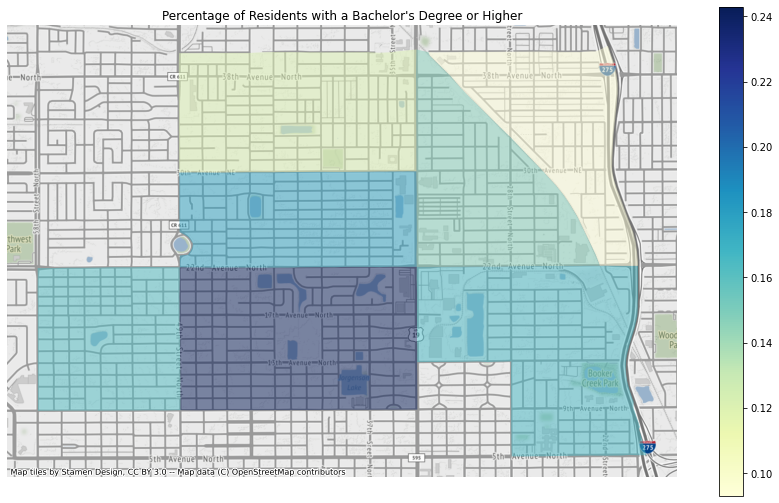

In [11]:
ax = merged.dropna().plot(
    column="percent_college",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis('off')
ax.set(title="Percentage of Residents with a Bachelor's Degree or Higher")

[Text(0.5, 1.0, 'Percentage of Residents Born in the United States')]

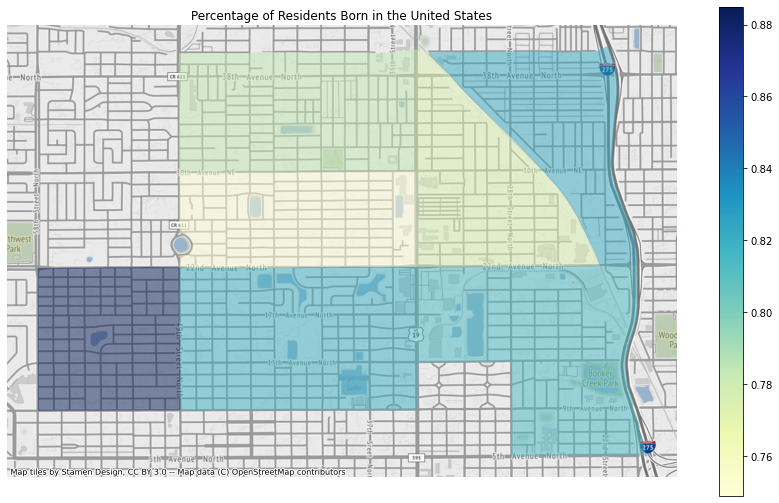

In [12]:
ax = merged.dropna().plot(
    column="percent_us_born",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis('off')
ax.set(title="Percentage of Residents Born in the United States")

[Text(0.5, 1.0, "Percentage of Residents Whose Race Is 'White Alone'")]

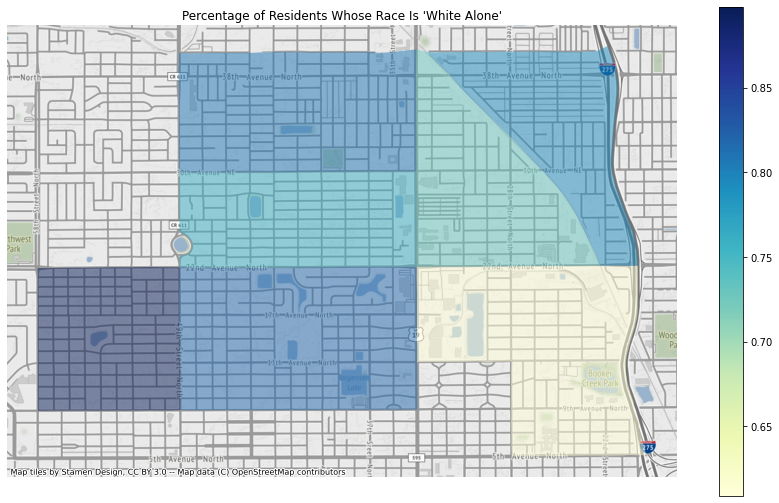

In [13]:
ax = merged.dropna().plot(
    column="percent_white",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis('off')
ax.set(title="Percentage of Residents Whose Race Is 'White Alone'")

[Text(0.5, 1.0, 'Percentage of Households That Got Public Assistance Income or Food Stamps in Past 12 Months')]

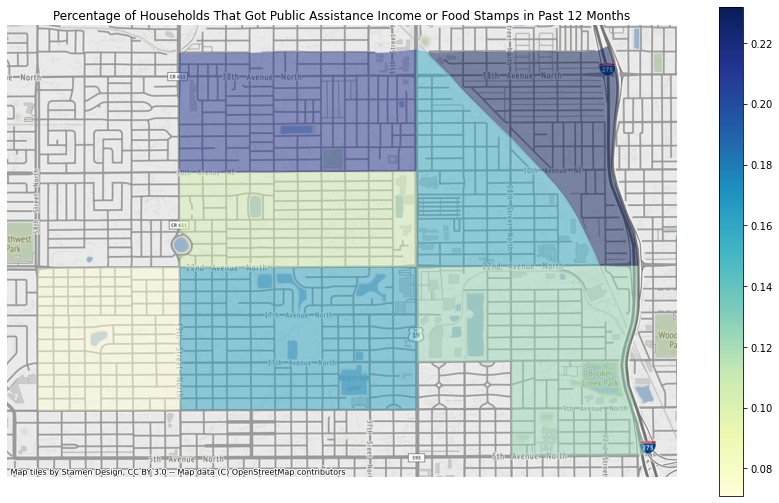

In [14]:
ax = merged.dropna().plot(
    column="percent_assistance",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis('off')
ax.set(title="Percentage of Households That Got Public Assistance Income or Food Stamps in Past 12 Months")

[Text(0.5, 1.0, 'Median Age')]

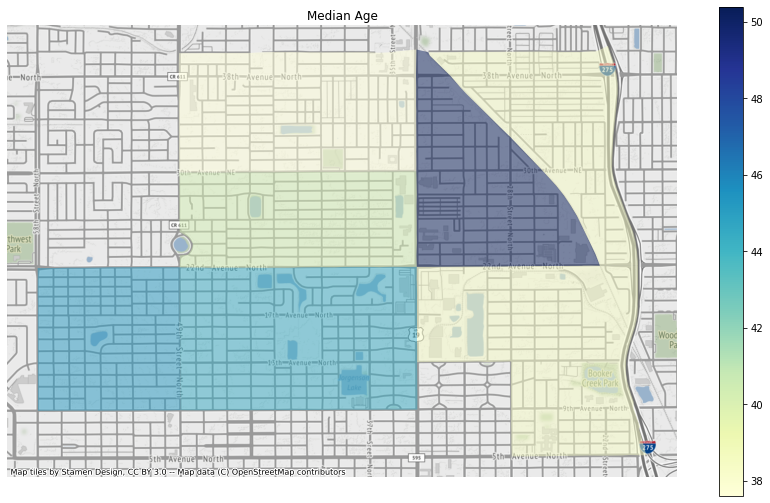

In [16]:
ax = merged.dropna().plot(
    column="median_age_total",
    cmap="YlGnBu",
    figsize=(15, 9),
    alpha=0.5,
    k=3,
    legend=True,
)
ctx.add_basemap(ax)
ax.axis('off')
ax.set(title="Median Age")